## Model Building in XGBoost

This is a great article for tunning XGboost: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [1]:
import os
windows=False
if (windows):
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import time
import csv
import boto # to download from AWS S3 buckets

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [6]:
#Let's define variables that will define the behaviour of the whole script
s3_path = 'http://bbts-kaggle.s3.amazonaws.com/bimbo/Pablo/'
use_validation=True
scale_numericals=True
onehot_categoricals=False
lag = 5
num_clusters_cliente = 400
shifted_target = True
trimmed = False

In [7]:
#now we load our modified train and test set
tic()
sufix=""
if (use_validation): sufix += "_holdout"
if (scale_numericals): sufix += "_scaled"
if (onehot_categoricals): sufix += "_onehot"
if (shifted_target): sufix += "_shifted"
sufix += "_" + repr(lag) + "lags"
sufix += "_" + repr(num_clusters_cliente) + "clusters"

print ('Downloading File: train_modified{}.csv  ...'.format(sufix))
train = pd.read_csv("{}train_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   )

print ('Downloading File: val_modified{}.csv  ...'.format(sufix))
val = pd.read_csv("{}val_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   ) 

print ('Downloading File: test_modified{}.csv  ...'.format(sufix))
test = pd.read_csv("{}test_modified{}.csv".format(s3_path,sufix),
                    dtype = {'id': 'uint32',
                            'Canal_ID': 'int8',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                      )
tac()

Time passed: 0hour:3min:4sec


In [8]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

## Train multiple models per client cluster

Ok, so we said on our prior step (Models wiht scikit-learn) that we need to deal with the data set high variance. Let's do this first:

Looking at the plot below, created on the clustering-by-demand on the feature engineering notebook, we see that some client clusters behave very differntly from others. So this explain why our model is failing on predicting accurately for all of them.
We are going then to create a wrapper function to create as many models as Client Clusters by demand are (Cliente_ID_clust_ID). The scores should be bettter individually, and the concatenation of all 400 models should yield a better overall RSMLE than our baseline 0.47.

![Image of Variables vs Hypothesis](./input-data/h2o-clustByDem_Cliente_ID_400.png)

In [9]:
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

def model_fit(alg, ctrain, cval, ctest, predictors, target, IDcol):
    
    #Fit the algorithm on the data
    watchlist = [(cval[predictors], cval[target])]
    alg.fit(ctrain[predictors], ctrain[target], eval_set=watchlist, eval_metric='rmse', early_stopping_rounds=20, verbose=False)

    #Predict training set:
    ctrain["predictions"] = alg.predict(ctrain[predictors])
    ctrain["predictions"] = np.maximum(ctrain["predictions"], 0)

    
    #Predict validation (holdout) set:
    cval["predictions"] = alg.predict(cval[predictors])
    cval["predictions"] = np.maximum(cval["predictions"], 0)# we make all negative numbers = 0 since there cannot be a negative demand

    
    #Predict on testing data: we need to revert it back to target by applying expm1
    ctest[target] = alg.predict(ctest[predictors])
    ctest[target] = np.maximum(ctest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    return ctrain[[target,"predictions"]], cval[[target,"predictions"]], ctest[[IDcol,target]]
    

In [10]:
def clusters_fit (alg, dtrain, dval, dtest, predictors, target, IDcol):
    
    train_predictions = pd.DataFrame(index=[target,"predictions"])
    val_predictions = pd.DataFrame(index=[target,"predictions"])
    test_predictions = pd.DataFrame(index=[IDcol,target])
    
    clusters_list = train.Cliente_ID_clust_ID.drop_duplicates().get_values()
    
    for cluster in clusters_list:
        
        #we get the cluster train,val, test data

        ctrain = dtrain.loc[dtrain["Cliente_ID_clust_ID"] == cluster]
        cval   = dval.loc[dval["Cliente_ID_clust_ID"] == cluster]
        ctest  = dtest.loc[dtest["Cliente_ID_clust_ID"] == cluster]
        
        #we train the cluster
        ctrain, cval, ctest = model_fit(model, ctrain, cval, ctest, predictors, target, IDcol)
        
        #concatenate each cluster result
        train_predictions = pd.concat([train_predictions,ctrain],ignore_index=True)
        val_predictions = pd.concat([val_predictions,cval],ignore_index=True)
        test_predictions = pd.concat([test_predictions,ctest],ignore_index=True)
        
        train_predictions.dropna(axis=0, how='any',inplace=True)
        val_predictions.dropna(axis=0, how='any',inplace=True)
        test_predictions.dropna(axis=0, how='any',inplace=True)
        
        
        
        rsmle_train =  np.sqrt(metrics.mean_squared_error(train_predictions[target], train_predictions["predictions"]))
        rsmle_val = np.sqrt(metrics.mean_squared_error(val_predictions[target], val_predictions["predictions"]))
        rows_pct = cval.shape[0]*100/dval.shape[0]
        
        if(rsmle_val > 0.48 and rows_pct > 0.8 ):
            print('Cluster: {:.0f}  RMSLE T: {:.4f} RMSLE V: {:.4f}  RowsPct: {:.4f}'.format(cluster,rsmle_train,rsmle_val,rows_pct))
    
    print()
        
    #For some reason this function is adding to NaN rows at the beggining, I don't know why, but we'll remove them

    
    return train_predictions[[target,"predictions"]], val_predictions[[target,"predictions"]], test_predictions[[IDcol,target]]
    

In [11]:
def report_submit(dtrain, dval, dtest, filename):
    
    #Print model report:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target], dtrain["predictions"])))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target], dval["predictions"])))
    
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(dtest[target])
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
  
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    #Export submission file:
    submission = dtest.copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

### Alg6 - XGB - Train each client cluster separately

Let's try training each of the client clusters separately and see if we have good results

In [ ]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']


model = xgb.XGBRegressor(n_estimators = 50, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

tic()
dt, dv, dte = clusters_fit(model, train, val, test, predictors, target, IDcol)
report_submit(dt, dv, dte, 'alg6.csv')
tac()



And now let's compare it with training the complete training set


Model Report
RMSLE TRAIN:  0.466831075031
RMSLE VAL:  0.471247724926
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0
MEAN TARGET PREDICTED:  5.170437812805176
MAX TARGET PREDICTED:  1229.15
Time passed: 0hour:4min:11sec


NameError: name 'plt' is not defined

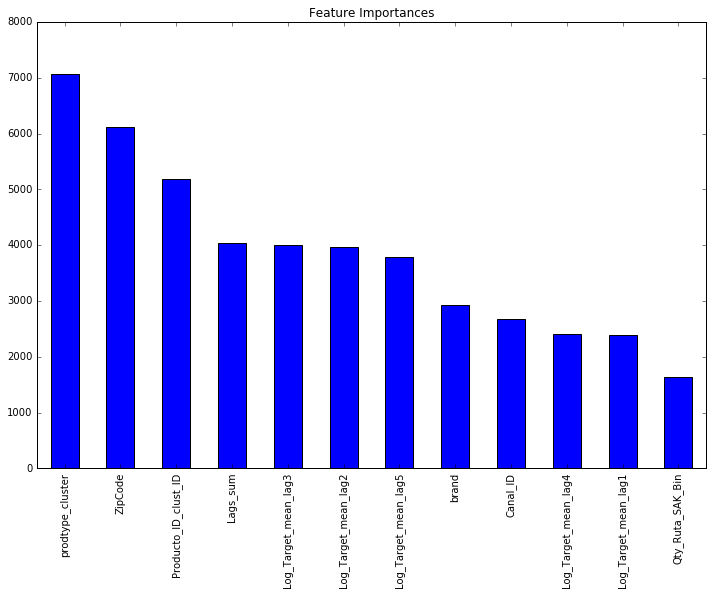

In [20]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']


model = xgb.XGBRegressor(n_estimators = 500, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

tic()
dt, dv, dte = model_fit(model, train, val, test, predictors, target, IDcol)
report_submit(dt, dv, dte, 'alg6.2.csv')
tac()

feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.plot(model.eval_results.values())